<a href="https://colab.research.google.com/github/zeyneppolat01/Datathon2024/blob/main/datathon24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the data from excel files
train_data = pd.read_excel('train.xlsx')
test_data = pd.read_excel('test_x.xlsx')


In [20]:
!pip install scikit-learn xgboost lightgbm catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 5.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import re
import numpy as np
from datetime import datetime
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor, OrthogonalMatchingPursuit
from sklearn.dummy import DummyRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:15: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


CİNSİYET SÜTUNU İŞLEMLERİ

In [3]:
# Cinsiyet sütunu için mapping işlemi
cinsiyet_mapping = {'Erkek': 0,'erkek':0, 'Kadın': 1,'kadın': 1}
train_data['Cinsiyet'] = train_data['Cinsiyet'].map(cinsiyet_mapping)
test_data['Cinsiyet'] = test_data['Cinsiyet'].map(cinsiyet_mapping)

DOĞUM TARİHİ SÜTUNU İŞLEMLERİ

In [4]:
# Doğum tarihini düzenleme (dayfirst=True parametresi ile)
train_data['Dogum Tarihi'] = pd.to_datetime(train_data['Dogum Tarihi'], errors='coerce', dayfirst=True)
test_data['Dogum Tarihi'] = pd.to_datetime(test_data['Dogum Tarihi'], errors='coerce', dayfirst=True)
# Yaş hesaplama (her satırdaki veriye göre)
train_data['Age'] = train_data['Basvuru Yili'] - train_data['Dogum Tarihi'].dt.year
test_data['Age'] = test_data['Basvuru Yili'] - test_data['Dogum Tarihi'].dt.year
# Dogum Tarihi sütununu çıkartma
train_data.drop('Dogum Tarihi', axis=1, inplace=True)
test_data.drop('Dogum Tarihi', axis=1, inplace=True)

DOĞUM YERİ, İKAMETGAH ŞEHRİ SUTUNLARI İŞLEMLERİ

In [5]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Türkiye'nin 81 ilini içeren bir liste (küçük harfe çevrildi)
cities = set(city.lower() for city in [
    "Adana", "Adıyaman", "Afyonkarahisar", "Ağrı", "Amasya", "Ankara", "Antalya",
    "Artvin", "Aydın", "Balıkesir", "Bilecik", "Bingöl", "Bitlis", "Bolu", "Burdur",
    "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", "Diyarbakır", "Edirne",
    "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane",
    "Hakkari", "Hatay", "Isparta", "Mersin", "İstanbul", "İzmir", "Kars", "Kastamonu",
    "Kayseri", "Kırklareli", "Kırşehir", "Kocaeli", "Konya", "Kütahya", "Malatya",
    "Manisa", "Kahramanmaraş", "Mardin", "Muğla", "Muş", "Nevşehir", "Niğde",
    "Ordu", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Tekirdağ",
    "Tokat", "Trabzon", "Tunceli", "Şanlıurfa", "Uşak", "Van", "Yozgat", "Zonguldak",
    "Aksaray", "Bayburt", "Karaman", "Kırıkkale", "Batman", "Şırnak", "Bartın",
    "Ardahan", "Iğdır", "Yalova", "Karabük", "Kilis", "Osmaniye", "Düzce"
])
city_numerics = {city: i + 1 for i, city in enumerate(cities)}

def normalize_city(city):
    #Şehir ismini normalize eder, tanınmıyorsa None döner.
    if city is None or pd.isna(city):
        return None
    city = str(city).lower().strip()  # NaN değerler için string'e çevir ve küçük harfe dönüştür
    return city if city in cities else None  # Türkiye illeri listesinde mi?

def process_city_column(column):
    """Verilen sütunu işler ve normalize eder."""
    return column.apply(lambda x: x.split('/')[0] if '/' in str(x) else x).apply(normalize_city).map(city_numerics)


# Sütunları normalize etme
train_data['Dogum Yeri'] = process_city_column(train_data['Dogum Yeri'])
train_data['Ikametgah Sehri'] = process_city_column(train_data['Ikametgah Sehri'])
test_data['Dogum Yeri'] = process_city_column(test_data['Dogum Yeri'])
test_data['Ikametgah Sehri'] = process_city_column(test_data['Ikametgah Sehri'])



ÜNİVERSİTE İLE İLGİLİ SÜTUNLARIN PREPROCESS İŞLEMLERİ

In [6]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd
import numpy as np
import re

sinif_mapping = {
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    'Mezun': 7,
    'Hazırlık': 0,
    'Yüksek lisans': 9,
    'Tez': 9,
    'Bilinmiyor': -1,
    '0': 0
}

train_data['Universite Kacinci Sinif'] = train_data['Universite Kacinci Sinif'].map(sinif_mapping)
test_data['Universite Kacinci Sinif'] = test_data['Universite Kacinci Sinif'].map(sinif_mapping)

# Universite Adi sütununu categorize_university fonksiyonu ile sınıflandır
def categorize_university(name):
    # Eğer isim NaN veya None ise, doğrudan 'Diğer' olarak etiketle
    if pd.isna(name):
        return 'Diğer'

    # Değilse, ismi küçük harfe çevir ve boşlukları temizle
    name = name.lower().strip()
    successful_universities = [
        r'\bboğaziçi\b', r'\bodtü\b', r'\bkoç\b', r'\bsabancı\b', r'\bbilkent\b',
        r'\bhacettepe\b', r'\bistanbul teknik\b', r'\bankara\b', r'\bistanbul\b',
        r'\bege\b', r'\bgazi\b', r'\byıldız teknik\b'
    ]

    # Regex kullanarak tam kelime eşleşmeleri ara
    if any(re.search(successful_uni, name) for successful_uni in successful_universities):
        return 'Başarılı Üniversite'
    else:
        return 'Diğer'

# Universite Adi sütununu başarlı/diğer olarak kategorize et
train_data['Universite Adi'] = train_data['Universite Adi'].apply(categorize_university)
test_data['Universite Adi'] = test_data['Universite Adi'].apply(categorize_university)

# LabelEncoding ile Universite Adi sütununu sayısal değerlere çevir
label_encoder = LabelEncoder()
train_data['Universite Adi'] = label_encoder.fit_transform(train_data['Universite Adi'])
test_data['Universite Adi'] = label_encoder.fit_transform(test_data['Universite Adi'])



uni_mapping = {'Devlet': 1, 'DEVLET': 1, 'Özel': 0, 'ÖZEL': 0}
burs_mapping = {'evet': 1, 'Evet': 1, 'EVET': 1,'Hayır': 0, 'hayır': 0}

train_data['Burs Aliyor mu?'] = train_data['Burs Aliyor mu?'].map(burs_mapping)
train_data['Universite Turu'] = train_data['Universite Turu'].map(uni_mapping)


test_data['Burs Aliyor mu?'] = test_data['Burs Aliyor mu?'].map(burs_mapping)
test_data['Universite Turu'] = test_data['Universite Turu'].map(uni_mapping)



def categorize_department(department):
    if pd.isna(department):
        return 'Diğer'
    if not isinstance(department, str):
        department = str(department)
    department = department.lower()
    # Mühendislik kelimesini ararken, 'mühendis' kelimesi içeren tüm ifadeleri yakala
    if re.search(r'\bmühendis\b', department):
        return 'Mühendislik'
    elif any(re.search(r'\b{}\b'.format(keyword), department) for keyword in ['siyaset', 'sosyal', 'ticaret', 'finans', 'psikoloji', 'sosyoloji', 'hukuk', 'iktisat', 'işletme', 'politika']):
        return 'Sosyal'
    elif any(re.search(r'\b{}\b'.format(keyword), department) for keyword in ['diş', 'hemşire', 'tıp', 'fizyo', 'genetik', 'eczacılık', 'biyoloji', 'biyo']):
        return 'Sağlık'
    return 'Diğer'

# Mapping
department_mapping = {
    'Mühendislik': 1,
    'Sosyal': 2,
    'Sağlık': 3,
    'Diğer': 4
}

train_data['Bölüm'] = train_data['Bölüm'].apply(categorize_department).map(department_mapping)
test_data['Bölüm'] = test_data['Bölüm'].apply(categorize_department).map(department_mapping)



# Universite Not Ortalamasi sütunundaki verileri işleme
def process_gpa(gpa):
    if pd.isna(gpa):
        return None  # Eğer veri NaN ise None dön

    # Veri sayısal türdeyse (int veya float), doğrudan döndür
    if isinstance(gpa, (int, float)):
        return gpa

    # String temizliği yap ve '-' ile ayır
    gpa = gpa.replace("ve altı", "").replace("ve üzeri", "").replace(" ", "").split("-")

    # String'i float'a çevirmeye çalış, başarısız olursa None dön
    try:
        gpa = [float(value) for value in gpa if value]  # Boş string'leri filtrele ve float'a çevir
        if len(gpa) == 2:
            return np.mean(gpa)  # Eğer iki değer varsa ortalamasını al
        elif gpa:
            return gpa[0]  # Tek bir değer varsa o değeri döndür
    except ValueError:  # Sayısal olmayan bir string varsa
        return None  # Hata durumunda None döndür

    return None  # Hiçbir koşul sağlanmazsa None döndür

train_data['Universite Not Ortalamasi'] = train_data['Universite Not Ortalamasi'].apply(process_gpa)
test_data['Universite Not Ortalamasi'] = test_data['Universite Not Ortalamasi'].apply(process_gpa)
#data['Universite Not Ortalamasi'].fillna(data['Universite Not Ortalamasi'].median(), inplace=True)

# Aykırı değerleri sınırlama
q_low = train_data['Universite Not Ortalamasi'].quantile(0.01)
q_high = train_data['Universite Not Ortalamasi'].quantile(0.99)
train_data['Universite Not Ortalamasi'] = np.clip(train_data['Universite Not Ortalamasi'], q_low, q_high)

# Aykırı değerleri sınırlama
q_low = test_data['Universite Not Ortalamasi'].quantile(0.01)
q_high = test_data['Universite Not Ortalamasi'].quantile(0.99)
test_data['Universite Not Ortalamasi'] = np.clip(test_data['Universite Not Ortalamasi'], q_low, q_high)

#Daha Once Baska Bir Universiteden Mezun Olmus 2023 SETİNDE YOK
train_data.drop('Daha Once Baska Bir Universiteden Mezun Olmus', axis=1, inplace=True)
#Burslu ise Burs Yuzdesi 2023 SETİNDE YOK
train_data.drop('Burslu ise Burs Yuzdesi', axis=1, inplace=True)

#Daha Once Baska Bir Universiteden Mezun Olmus 2023 SETİNDE YOK
test_data.drop('Daha Once Baska Bir Universiteden Mezun Olmus', axis=1, inplace=True)
#Burslu ise Burs Yuzdesi 2023 SETİNDE YOK
test_data.drop('Burslu ise Burs Yuzdesi', axis=1, inplace=True)
# Sonuçları kontrol etme
print(train_data.head())
print(test_data.head())


   Basvuru Yili  Degerlendirme Puani  Cinsiyet  Dogum Yeri  Ikametgah Sehri  \
0        2014.0                 52.0       0.0         NaN              3.0   
1        2014.0                 30.0       0.0         NaN             50.0   
2        2014.0                 18.0       0.0        48.0             50.0   
3        2014.0                 40.0       0.0         2.0             50.0   
4        2014.0                 24.0       0.0         3.0              3.0   

   Universite Adi  Universite Turu  Burs Aliyor mu?  Bölüm  \
0               1              0.0              1.0      4   
1               1              0.0              0.0      4   
2               1              0.0              0.0      2   
3               1              0.0              1.0      4   
4               1              0.0              1.0      2   

   Universite Kacinci Sinif  ...  Aktif olarak bir STK üyesi misiniz?  \
0                       3.0  ...                                Hayır   
1     

LİSE İLE İLGİLİ SÜTUNLARIN PREPROCESS İŞLEMLERİ

In [7]:
#lise adı gereksiz
train_data.drop('Lise Adi', axis=1, inplace=True)
test_data.drop('Lise Adi', axis=1, inplace=True)
#lise adı diğer gereksiz
train_data.drop('Lise Adi Diger', axis=1, inplace=True)
test_data.drop('Lise Adi Diger', axis=1, inplace=True)
# 'Lise Bolum Diger' gereksiz
train_data.drop('Lise Bolum Diger', axis=1, inplace=True)
test_data.drop('Lise Bolum Diger', axis=1, inplace=True)
#Lise Sehir gereksiz
train_data.drop('Lise Sehir', axis=1, inplace=True)
test_data.drop('Lise Sehir', axis=1, inplace=True)


# Lise türlerini yeniden sınıflandırma ve mapping uygulama
def reclassify_school_type(school_type):
    # Eğer veri NaN ise veya None ise, doğrudan 'Diğer' olarak döndür
    if pd.isna(school_type):
        return 'Diğer'

    # Veri tipini kontrol et, eğer string değilse string'e çevir
    if not isinstance(school_type, str):
        school_type = str(school_type)

    school_type = school_type.lower()
    # Farklı varyasyonları aynı kategoriye indirgeme
    #devlet ve düz aynı kategoride, efektif sonuç alınmazsa ayrılıcak
    if any(keyword in school_type for keyword in ['devlet', 'düz', 'resmi']):
        return 'Devlet'
    elif any(keyword in school_type for keyword in ['özel', 'kolej']):
        return 'Özel'
    elif any(keyword in school_type for keyword in ['anadolu']):
        return 'Anadolu'
    elif any(keyword in school_type for keyword in ['fen']):
        return 'Fen'
    elif any(keyword in school_type for keyword in ['meslek']):
        return 'Meslek'
    else:
        return 'Diğer'

# 'Lise Turu' sütununu yeniden sınıflandırma ve mapping işlemi
train_data['Lise Turu'] = train_data['Lise Turu'].apply(reclassify_school_type)
test_data['Lise Turu'] = test_data['Lise Turu'].apply(reclassify_school_type)

# 'Lise Turu' Mapping işlemi
school_type_mapping = {'Devlet': 0, 'Özel': 1, 'Anadolu': 2, 'Fen': 3, 'Meslek': 4, 'Diğer': 5}
train_data['Lise Turu'] = train_data['Lise Turu'].map(school_type_mapping)
test_data['Lise Turu'] = test_data['Lise Turu'].map(school_type_mapping)

# Yeni veriyi kontrol et
print(train_data['Lise Turu'].value_counts())
print(test_data['Lise Turu'].value_counts())


# Lise bölümlerini yeniden sınıflandırma ve mapping uygulama
def standardize_department(department):
    # Eğer veri NaN ise veya None ise, doğrudan 'Diğer' olarak döndür
    if pd.isna(department):
        return 'Diğer'

    # Veri tipini kontrol et, eğer string değilse string'e çevir
    if not isinstance(department, str):
        department = str(department)
    department = department.lower()
    if any(keyword in department for keyword in ['sayısal', 'fen', 'mf']):
        return 'MF'
    elif any(keyword in department for keyword in ['eşit', 'tm']):
        return 'TM'
    elif 'sözel' in department:
        return 'Sözel'
    elif 'dil' in department:
        return 'Dil'
    else:
        return 'Diğer'

# 'Lise Bolumu' sütununu düzenleme
train_data['Lise Bolumu'] = train_data['Lise Bolumu'].apply(standardize_department)

# Mapping işlemi
department_mapping = {'MF': 0, 'TM': 1, 'Sözel': 2, 'Dil': 3, 'Diğer': 4}
train_data['Lise Bolumu'] = train_data['Lise Bolumu'].map(department_mapping)

# Yeni veriyi kontrol et
print(train_data['Lise Bolumu'].value_counts())

# 'Lise Bolumu' sütununu düzenleme
test_data['Lise Bolumu'] = test_data['Lise Bolumu'].apply(standardize_department)
test_data['Lise Bolumu'] = test_data['Lise Bolumu'].map(department_mapping)
print(test_data['Lise Bolumu'].value_counts())


#LİSE NOTLAR

def parse_grades(grade):
    # Eğer veri NaN ise veya None ise, doğrudan None döndür
    if pd.isna(grade):
        return None

    # Veri tipini kontrol et, eğer string değilse string'e çevir
    if not isinstance(grade, str):
        grade = str(grade)
    # Not aralığını bul ve orta noktasını hesapla
    if '-' in grade:
        parts = grade.split('-')
        try:
            low = float(parts[0].strip())
            high = float(parts[1].strip())
            # Aralık düzgün sıralanmamışsa düzelt
            low, high = min(low, high), max(low, high)
            average = (low + high) / 2
        except ValueError:
            # Sayısal olmayan bir string varsa hata durumunda None döndür
            return None
    else:
        try:
            average = float(grade.strip())
        except ValueError:
            return None

    # Dörtlük sisteme dönüştür (varsayılan olarak yüzlük sistemde olduğunu kabul eder)
    if average > 4:  # Yüzlük sistemden dörtlük sisteme çevir
        return np.round(4 * average / 100, 2)
    return average

# 'Lise Mezuniyet Notu' sütununu düzenleme
train_data['Lise Mezuniyet Notu'] = train_data['Lise Mezuniyet Notu'].astype(str).apply(parse_grades)

# Yeni veriyi kontrol et
print(train_data['Lise Mezuniyet Notu'].head())

# 'Lise Mezuniyet Notu' sütununu düzenleme
test_data['Lise Mezuniyet Notu'] = test_data['Lise Mezuniyet Notu'].astype(str).apply(parse_grades)

# Yeni veriyi kontrol et
print(test_data['Lise Mezuniyet Notu'].head())

Lise Turu
2    20369
5    15191
0    13171
1     7041
4     6535
3     2819
Name: count, dtype: int64
Lise Turu
0    9242
1    1807
Name: count, dtype: int64
Lise Bolumu
0    34750
1    18093
4     7268
2     3694
3     1321
Name: count, dtype: int64
Lise Bolumu
0    6354
1    3224
2    1152
3     319
Name: count, dtype: int64
0    3.25
1    3.50
2    3.25
3    3.25
4    3.50
Name: Lise Mezuniyet Notu, dtype: float64
0    2.48
1    3.50
2    2.48
3    3.50
4    3.50
Name: Lise Mezuniyet Notu, dtype: float64


BAŞKA KURUM BURSLARI İLE İLGİLİ SÜTUNLARIN PREPROCESS İŞLEMLERİ

In [8]:
#Baska Bir Kurumdan Burs Aliyor mu? cevabı Mapping işlemi
burs_cevap_mapping = {'Evet': 1, 'Hayır': 0}
train_data['Baska Bir Kurumdan Burs Aliyor mu?'] = train_data['Baska Bir Kurumdan Burs Aliyor mu?'].map(burs_cevap_mapping)
test_data['Baska Bir Kurumdan Burs Aliyor mu?'] = test_data['Baska Bir Kurumdan Burs Aliyor mu?'].map(burs_cevap_mapping)

#BURS ALINAN BASKA KURUM
def standardize_institution(name):
    # Eğer veri NaN ise veya None ise, doğrudan 'Diğer' olarak döndür
    if pd.isna(name):
        return 'Diğer'

    # Veri tipini kontrol et, eğer string değilse string'e çevir
    if not isinstance(name, str):
        name = str(name)

    name = name.lower()
    if any(kyk in name for kyk in ['kredi yurtlar kurumu', 'kyk bursu', 't.c kredi ve yurtlar kurumu', 'kyk devlet bursu']):
        return 'KYK'
    # diğer kurumlar
    else:
        return 'Diğer'
burs_kurumu_mapping = {'KYK': 1, 'Diğer': 0}
train_data['Burs Aldigi Baska Kurum'] = train_data['Burs Aldigi Baska Kurum'].astype(str).apply(standardize_institution).map(burs_kurumu_mapping)
test_data['Burs Aldigi Baska Kurum'] = test_data['Burs Aldigi Baska Kurum'].astype(str).apply(standardize_institution).map(burs_kurumu_mapping)


#BURS ALINAN BASKA KURUM ÜCRETI (Enflasyon Faktörü dahil)
import re

def parse_amount(amount):
    # Önce rakamları ayıklıyoruz
    if pd.isna(amount):
        return None  # NaN değerleri için doğrudan None döndür

    # String dışındaki türleri string'e çevir
    if not isinstance(amount, str):
        amount = str(amount)

    # Önce rakamları ayıklıyoruz
    amounts = re.findall(r'\d+', amount.replace('.', ''))
    amounts = [int(amt) for amt in amounts if amt.isdigit()]  # Sadece rakam içeren string'leri int'e çevir
    if amounts:
        return sum(amounts) / len(amounts)  # Ortalama değeri döndürür
    return None  # Rakam bulunamazsa None döndür

train_data['Baska Kurumdan Aldigi Burs Miktari'] = train_data['Baska Kurumdan Aldigi Burs Miktari'].astype(str).apply(parse_amount)
test_data['Baska Kurumdan Aldigi Burs Miktari'] = test_data['Baska Kurumdan Aldigi Burs Miktari'].astype(str).apply(parse_amount)

# Gerçek enflasyon oranları, kaynak olarak Türkiye Cumhuriyeti Merkez Bankası verileri kullanıldı
inflation_rates = {
    2014: 8.17, 2015: 8.81, 2016: 8.53, 2017: 11.92, 2018: 20.30, 2019: 11.84, 2020: 12.15, 2021: 14.97, 2022: 61.36, 2023: 53.86  # Yüzde olarak ifade edilmiştir
}

# Her yıl için birikimli enflasyon faktörünü hesapla
cumulative_inflation = {2023: 1}  # 2023 baz yılı olarak belirlendi
for year in range(2022, 2013, -1):
    cumulative_inflation[year] = cumulative_inflation[year + 1] * (inflation_rates[year] / 100 + 1)

# Enflasyon faktörlerini tersine çevirerek düzeltilmiş değerleri hesapla
adjusted_inflation = {year: 1 / factor for year, factor in cumulative_inflation.items()}

def adjust_for_inflation(amount, year):
    if pd.isna(amount):
        return None
    rate = adjusted_inflation.get(year, 1)
    return amount * rate
#enflasyona göre Duzenlenmis Burs Miktari
train_data['Baska Kurumdan Aldigi Burs Miktari'] = train_data.apply(lambda row: adjust_for_inflation(row['Baska Kurumdan Aldigi Burs Miktari'], row['Basvuru Yili']), axis=1)
test_data['Baska Kurumdan Aldigi Burs Miktari'] = test_data.apply(lambda row: adjust_for_inflation(row['Baska Kurumdan Aldigi Burs Miktari'], row['Basvuru Yili']), axis=1)

print(train_data)

       Basvuru Yili  Degerlendirme Puani  Cinsiyet  Dogum Yeri  \
0            2014.0                 52.0       0.0         NaN   
1            2014.0                 30.0       0.0         NaN   
2            2014.0                 18.0       0.0        48.0   
3            2014.0                 40.0       0.0         2.0   
4            2014.0                 24.0       0.0         3.0   
...             ...                  ...       ...         ...   
65121        2022.0                  0.0       0.0        50.0   
65122        2022.0                  0.0       0.0        11.0   
65123        2022.0                  0.0       0.0         4.0   
65124        2022.0                  0.0       0.0        48.0   
65125        2022.0                  NaN       1.0        11.0   

       Ikametgah Sehri  Universite Adi  Universite Turu  Burs Aliyor mu?  \
0                  3.0               1              0.0              1.0   
1                 50.0               1              0.0

ANNE BABA BİLGİLERİ

In [9]:
egitim_mapping = {
    'İlkokul': 1,
    'İlkokul Mezunu': 1,
    'İLKOKUL MEZUNU': 1,
    'Eğitimi yok': 0,
    'EĞİTİM YOK': 0,
    'Eğitim Yok': 0,
    'Ortaokul': 2,
    'Ortaokul Mezunu': 2,
    'ORTAOKUL MEZUNU': 2,
    'Lise': 3,
    'LİSE': 3,
    'Lise Mezunu': 3,
    'Üniversite': 4,
    'ÜNİVERSİTE': 4,
    'Üniversite Mezunu': 4,
    'Yüksek Lisans': 5,
    'YÜKSEK LİSANS': 5,
    'Yüksek Lisans / Doktora': 5,
    'Yüksek Lisans / Doktara': 5,
    'Doktora': 6,
    'DOKTORA': 6
}

# Eğitim durumunu standardize etme
train_data['Anne Egitim Durumu'] = train_data['Anne Egitim Durumu'].map(egitim_mapping)
train_data['Baba Egitim Durumu'] = train_data['Baba Egitim Durumu'].map(egitim_mapping)

# Eğitim durumunu standardize etme test
test_data['Anne Egitim Durumu'] = test_data['Anne Egitim Durumu'].map(egitim_mapping)
test_data['Baba Egitim Durumu'] = test_data['Baba Egitim Durumu'].map(egitim_mapping)

#Anne baba Calisma Durumu cevabı Mapping işlemi
calisma_durumu_mapping = {'Evet': 2,'Emekli': 1, 'Hayır': 0}
train_data['Anne Calisma Durumu'] = train_data['Anne Calisma Durumu'].map(burs_cevap_mapping)
train_data['Baba Calisma Durumu'] = train_data['Baba Calisma Durumu'].map(burs_cevap_mapping)

test_data['Anne Calisma Durumu'] = test_data['Anne Calisma Durumu'].map(burs_cevap_mapping)
test_data['Baba Calisma Durumu'] = test_data['Baba Calisma Durumu'].map(burs_cevap_mapping)

sector_mapping = {'0': 0, '-': 0,'Özel Sektör':1,'ÖZEL SEKTÖR':1,'Diğer':1,'DİĞER':1,'Kamu':2,'KAMU':2}
# Sektör bilgisini standardize etme
train_data['Anne Sektor'] = train_data['Anne Sektor'].map(sector_mapping)
train_data['Baba Sektor'] = train_data['Baba Sektor'].map(sector_mapping)

test_data['Anne Sektor'] = test_data['Anne Sektor'].map(sector_mapping)
test_data['Baba Sektor'] = test_data['Baba Sektor'].map(sector_mapping)

# Yeni veriyi kontrol et
print(train_data[['Anne Egitim Durumu', 'Baba Egitim Durumu', 'Anne Sektor', 'Baba Sektor']].head())

   Anne Egitim Durumu  Baba Egitim Durumu  Anne Sektor  Baba Sektor
0                 4.0                 4.0          0.0          0.0
1                 4.0                 5.0          2.0          0.0
2                 1.0                 1.0          0.0          1.0
3                 1.0                 4.0          0.0          0.0
4                 1.0                 4.0          0.0          0.0


KULÜP/SPOR VB PREPROCESS

In [10]:
giris_kulub_mapping = {'Hayır': 0, 'Evet': 1}
train_data['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = train_data['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].map(giris_kulub_mapping)
test_data['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'] = test_data['Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?'].map(giris_kulub_mapping)

#Kulubun Ismi gereksiz
train_data.drop('Uye Oldugunuz Kulubun Ismi', axis=1, inplace=True)
test_data.drop('Uye Oldugunuz Kulubun Ismi', axis=1, inplace=True)

spor_mapping = {'Hayır': 0, 'Evet': 1}
train_data['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = train_data['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].map(spor_mapping)
test_data['Profesyonel Bir Spor Daliyla Mesgul musunuz?'] = test_data['Profesyonel Bir Spor Daliyla Mesgul musunuz?'].map(spor_mapping)

spor_rol_mapping = {'0': 0, '-': 0,'Diğer':0,'DİĞER':0,'Bireysel':1,'Takım Oyuncusu':1,'Lider/Kaptan':2,'KAPTAN / LİDER':2,'Kaptan':2}
train_data['Spor Dalindaki Rolunuz Nedir?'] = train_data['Spor Dalindaki Rolunuz Nedir?'].map(spor_rol_mapping)
test_data['Spor Dalindaki Rolunuz Nedir?'] = test_data['Spor Dalindaki Rolunuz Nedir?'].map(spor_rol_mapping)

stk_mapping = {'Hayır': 0, 'Evet': 1}
train_data['Aktif olarak bir STK üyesi misiniz?'] = train_data['Aktif olarak bir STK üyesi misiniz?'].map(stk_mapping)
test_data['Aktif olarak bir STK üyesi misiniz?'] = test_data['Aktif olarak bir STK üyesi misiniz?'].map(stk_mapping)

#Hangi STK'nin Uyesisiniz? gereksiz
train_data.drop("Hangi STK'nin Uyesisiniz?", axis=1, inplace=True)
test_data.drop("Hangi STK'nin Uyesisiniz?", axis=1, inplace=True)

#Stk Projesine Katildiniz Mi? 2023 setinde yok
train_data.drop("Stk Projesine Katildiniz Mi?", axis=1, inplace=True)
test_data.drop("Stk Projesine Katildiniz Mi?", axis=1, inplace=True)

girisim_mapping = {'Hayır': 0, 'Evet': 1}
train_data['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = train_data['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].map(girisim_mapping)
test_data['Girisimcilikle Ilgili Deneyiminiz Var Mi?'] = test_data['Girisimcilikle Ilgili Deneyiminiz Var Mi?'].map(girisim_mapping)

#Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz? gereksiz
train_data.drop('Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?', axis=1, inplace=True)
test_data.drop('Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?', axis=1, inplace=True)

ing_mapping = {'Hayır': 0, 'Evet': 1}
train_data['Ingilizce Biliyor musunuz?'] = train_data['Ingilizce Biliyor musunuz?'].map(ing_mapping)
test_data['Ingilizce Biliyor musunuz?'] = test_data['Ingilizce Biliyor musunuz?'].map(ing_mapping)

ing_seviye_mapping = {'0': 0, 'Başlangıç': 1,'Orta':2,'İleri':3}
train_data['Ingilizce Seviyeniz?'] = train_data['Ingilizce Seviyeniz?'].map(ing_seviye_mapping)
test_data['Ingilizce Seviyeniz?'] = test_data['Ingilizce Seviyeniz?'].map(ing_seviye_mapping)

#Ingilizce Seviyeniz? 2023 setinde yok
train_data.drop('Ingilizce Seviyeniz?', axis=1, inplace=True)
test_data.drop('Ingilizce Seviyeniz?', axis=1, inplace=True)

#Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite gereksiz
train_data.drop('Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite', axis=1, inplace=True)
test_data.drop('Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite', axis=1, inplace=True)


In [12]:
print(train_data.head())

   Basvuru Yili  Degerlendirme Puani  Cinsiyet  Dogum Yeri  Ikametgah Sehri  \
0        2014.0                 52.0       0.0         NaN             61.0   
1        2014.0                 30.0       0.0         NaN             16.0   
2        2014.0                 18.0       0.0        26.0             16.0   
3        2014.0                 40.0       0.0        66.0             16.0   
4        2014.0                 24.0       0.0        61.0             61.0   

   Universite Adi  Universite Turu  Burs Aliyor mu?  Bölüm  \
0               1              0.0              1.0      4   
1               1              0.0              0.0      4   
2               1              0.0              0.0      2   
3               1              0.0              1.0      4   
4               1              0.0              1.0      2   

   Universite Kacinci Sinif  ...  Baba Sektor  Kardes Sayisi  \
0                       3.0  ...          0.0            1.0   
1                       

NULL DEĞERLER İÇİN KNN

In [11]:
#------------IMPUTE----------------------------

from sklearn.impute import KNNImputer

# 'Değerlendirme Puanı' dışındaki sütunları seç
predictors = train_data.drop(columns=['Degerlendirme Puani'])

# Non-target sütunları sayısallaştır
for column in predictors.columns:
    predictors[column] = pd.to_numeric(predictors[column], errors='coerce')

# KNN Imputer uygula ve train setini fit et
knn_imputer = KNNImputer(n_neighbors=5)
train_data_imputed = pd.DataFrame(knn_imputer.fit_transform(predictors), columns=predictors.columns)

# İmpute edilmiş verileri hedef sütunla birleştir
train_data_imputed = pd.concat([train_data_imputed, train_data['Degerlendirme Puani']], axis=1)

# Eksik veri kalmadığını kontrol et
print(train_data_imputed.isnull().sum())

# Test setinde de sütunları sayısallaştır
for column in test_data.columns:
    test_data[column] = pd.to_numeric(test_data[column], errors='coerce')

# Train setinde fit edilen imputer ile test setini transform et
test_data_imputed = pd.DataFrame(knn_imputer.transform(test_data), columns=test_data.columns)

# Eksik veri kalmadığını kontrol et
print(test_data_imputed.isnull().sum())


Basvuru Yili                                            0
Cinsiyet                                                0
Dogum Yeri                                              0
Ikametgah Sehri                                         0
Universite Adi                                          0
Universite Turu                                         0
Burs Aliyor mu?                                         0
Bölüm                                                   0
Universite Kacinci Sinif                                0
Universite Not Ortalamasi                               0
Lise Turu                                               0
Lise Bolumu                                             0
Lise Mezuniyet Notu                                     0
Baska Bir Kurumdan Burs Aliyor mu?                      0
Burs Aldigi Baska Kurum                                 0
Baska Kurumdan Aldigi Burs Miktari                      0
Anne Egitim Durumu                                      0
Anne Calisma D

In [12]:
# Hedef değişkenin medyanını hesapla
median_value = train_data_imputed['Degerlendirme Puani'].median()

# Eksik değerleri medyan ile doldur
train_data_imputed['Degerlendirme Puani'].fillna(median_value, inplace=True)

# 'id' sütununu kaldırmayı unuttuğum için bu adımda onu da ekliyorum
train_data_imputed = train_data_imputed.drop(columns=['id'])

# Eksik veri kalmadığını kontrol et
print(train_data_imputed['Degerlendirme Puani'].isnull().sum())


0


DATASET IMBALANCE MI DİYE KONTROL EDİYORUZ

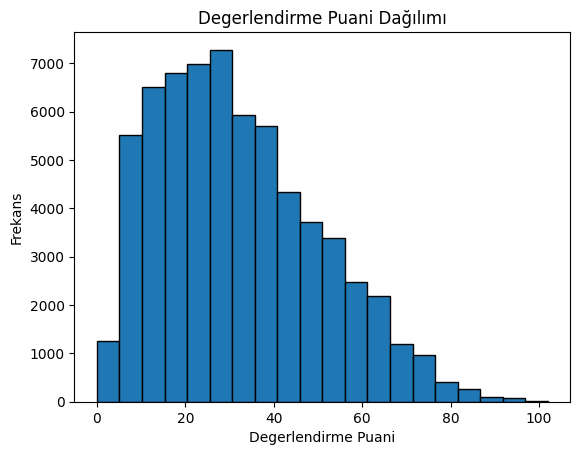

In [13]:
import matplotlib.pyplot as plt

# Histogram ile puanların dağılımını görselleştirme
plt.hist(train_data_imputed["Degerlendirme Puani"], bins=20, edgecolor='black')
plt.xlabel('Degerlendirme Puani')
plt.ylabel('Frekans')
plt.title('Degerlendirme Puani Dağılımı')
plt.show()

CONTINUOUS TARGET DEĞİŞKENE SAHİP OLDUĞUMUZ İÇİN LOG GÖNÜŞÜMÜ

In [14]:
# Log dönüşümü uygulayarak yeni bir sütun oluşturuyoruz
# Sıfır değerlerin olmamasını sağlamak için np.log1p kullanıyoruz

# Öncelikle, log dönüşümü yapmadan önce 'Degerlendirme Puani' sütununda
# sıfır veya negatif değerler olmadığından emin olun. Eğer bu tür değerler varsa:
train_data_imputed['Degerlendirme Puani'] += 1  # Sıfırı önlemek için her değere 1 ekleyin

# Log dönüşümünü uygulama
train_data_imputed['Log_Degerlendirme_Puani'] = np.log(train_data_imputed['Degerlendirme Puani'])

# Sonuçları göstermek için DataFrame'in ilk birkaç satırını yazdır
print(train_data_imputed[['Degerlendirme Puani', 'Log_Degerlendirme_Puani']].head())

   Degerlendirme Puani  Log_Degerlendirme_Puani
0                 53.0                 3.970292
1                 31.0                 3.433987
2                 19.0                 2.944439
3                 41.0                 3.713572
4                 25.0                 3.218876


SCALE İŞLEMLERİ

In [15]:
from sklearn.preprocessing import StandardScaler

# Ölçekleyiciyi yarat
scaler = StandardScaler()

# Ölçeklenecek sütunları belirle
scale_columns = train_data_imputed.drop(columns=['Degerlendirme Puani', 'Log_Degerlendirme_Puani']).columns
# Train set için ölçekleyiciyi fit et ve transform et
train_predictors_scaled = scaler.fit_transform(train_data_imputed[scale_columns])

# Test seti için sadece transform uygula
test_predictors_scaled = scaler.transform(test_data_imputed[scale_columns])

# DataFrame'lere dönüştür
train_predictors_scaled = pd.DataFrame(train_predictors_scaled, columns=scale_columns)
test_predictors_scaled = pd.DataFrame(test_predictors_scaled, columns=scale_columns)

# İmpute edilmiş ve ölçeklendirilmiş train verisini hedef sütunla birleştir
train_data_final = pd.concat([train_predictors_scaled, train_data_imputed[['Degerlendirme Puani', 'Log_Degerlendirme_Puani']]], axis=1)

# Sonuçları kontrol et
print(train_data_final.head())
print(test_predictors_scaled.head())


   Basvuru Yili  Cinsiyet  Dogum Yeri  Ikametgah Sehri  Universite Adi  \
0     -1.602011 -1.349919   -0.528600        -1.713481        0.360001   
1     -1.602011 -1.349919    0.848025         0.564925        0.360001   
2     -1.602011 -1.349919    0.482798         0.564925        0.360001   
3     -1.602011 -1.349919   -1.671106         0.564925        0.360001   
4     -1.602011 -1.349919   -1.624282        -1.713481        0.360001   

   Universite Turu  Burs Aliyor mu?     Bölüm  Universite Kacinci Sinif  \
0        -2.143604         2.014499  0.467294                  0.409685   
1        -2.143604        -0.496425  0.467294                  0.409685   
2        -2.143604        -0.496425 -2.397526                 -1.368583   
3        -2.143604         2.014499  0.467294                  0.409685   
4        -2.143604         2.014499 -2.397526                 -0.479449   

   Universite Not Ortalamasi  ...  Kardes Sayisi  \
0                   0.850668  ...      -0.727713   


RFECV İLE FEATURE SELECTION

In [24]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

# Modeli ve RFECV seçiciyi oluştur
estimator = RandomForestRegressor(n_jobs=-1)
selector = RFECV(estimator, step=5, cv=KFold(4), scoring='neg_mean_squared_error')

# Özellikleri ve hedef değişkeni ayır
X = train_data_final.drop(columns=['Degerlendirme Puani', 'Log_Degerlendirme_Puani'])
y = train_data_final['Log_Degerlendirme_Puani']

# RFECV ile özellik seçimi yap
selector.fit(X, y)

# Seçilen özellikleri göster
selected_columns = X.columns[selector.support_]
print("RFECV ile Seçilen Özellikler:", selected_columns)

# Optimal özellik sayısını ve çapraz doğrulama skorunu yazdır
print("Optimal özellik sayısı:", selector.n_features_)


RFECV ile Seçilen Özellikler: Index(['Basvuru Yili', 'Cinsiyet', 'Dogum Yeri', 'Ikametgah Sehri',
       'Universite Adi', 'Universite Turu', 'Burs Aliyor mu?', 'Bölüm',
       'Universite Kacinci Sinif', 'Universite Not Ortalamasi', 'Lise Turu',
       'Lise Bolumu', 'Lise Mezuniyet Notu',
       'Baska Bir Kurumdan Burs Aliyor mu?', 'Burs Aldigi Baska Kurum',
       'Baska Kurumdan Aldigi Burs Miktari', 'Anne Egitim Durumu',
       'Anne Calisma Durumu', 'Anne Sektor', 'Baba Egitim Durumu',
       'Baba Calisma Durumu', 'Baba Sektor', 'Kardes Sayisi',
       'Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?',
       'Profesyonel Bir Spor Daliyla Mesgul musunuz?',
       'Spor Dalindaki Rolunuz Nedir?', 'Aktif olarak bir STK üyesi misiniz?',
       'Girisimcilikle Ilgili Deneyiminiz Var Mi?',
       'Ingilizce Biliyor musunuz?', 'Age'],
      dtype='object')
Optimal özellik sayısı: 30


AttributeError: 'RFECV' object has no attribute 'grid_scores_'

In [25]:
# En iyi skorları bulmak için 'grid_scores_' değil 'cv_results_' özelliğini kullanıyoruz
if 'mean_test_score' in selector.cv_results_:
    best_score = np.max(selector.cv_results_['mean_test_score'])
    print("En iyi skor:", best_score)
else:
    print("Detaylı skor bilgileri cv_results_ içinde bulunamadı.")

En iyi skor: -0.11648808418436339


In [26]:
best_score = np.max(selector.cv_results_['mean_test_score'])
rmse = np.sqrt(-best_score)  # Negatif değeri pozitife çevir ve karekökünü al
print("En iyi RMSE skoru:", rmse)


En iyi RMSE skoru: 0.341303507430503


MODELLER

In [27]:
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_regression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, BayesianRidge, Lars, LassoLars
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, HistGradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import HuberRegressor, OrthogonalMatchingPursuit
from sklearn.dummy import DummyRegressor
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostRegressor

import numpy as np
import pandas as pd

# Seçilen özellikleri içeren DataFrame
X_selected = X[selected_columns]


# Regresyon modellerini tanımla
regressors = {
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1),
    "DecisionTreeRegressor": DecisionTreeRegressor(),
    "GradientBoostingRegressor": GradientBoostingRegressor(),
    "KNeighborsRegressor": KNeighborsRegressor(),
    "LinearRegression": LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'Elastic Net': ElasticNet(),
    'Bayesian Ridge': BayesianRidge(),
    'Least Angle Regression': Lars(),
    'Lasso Least Angle Regression': LassoLars(),
    'Gradient Boosting Regressor': GradientBoostingRegressor(),
    'Random Forest Regressor': RandomForestRegressor(),
    'Extra Trees Regressor': ExtraTreesRegressor(),
    'AdaBoost Regressor': AdaBoostRegressor(),
    'K Neighbors Regressor': KNeighborsRegressor(),
    'Huber Regressor': HuberRegressor(),
    'Orthogonal Matching Pursuit': OrthogonalMatchingPursuit(),
    'Dummy Regressor': DummyRegressor(strategy='mean'),
    'Extreme Gradient Boosting': xgb.XGBRegressor(),
    'Light Gradient Boosting Machine': lgb.LGBMRegressor(),
    'CatBoost Regressor': CatBoostRegressor(learning_rate=0.1, depth=6, iterations=500, verbose=0),
    'Hist Gradient Boosting Regressor': HistGradientBoostingRegressor()

}

# RMSE hesaplama fonksiyonu
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# RMSE skorlayıcıyı tanımla
rmse_scorer = make_scorer(rmse, greater_is_better=False)

# Sonuçlar için DataFrame oluştur
results_df = pd.DataFrame(columns=['Model', 'RMSE'])

# KFold nesnesi cross-validation için
kf = KFold(n_splits=3, shuffle=True, random_state=42)
# Her bir regresör için çapraz doğrulama yap
for name, regressor in regressors.items():
    scores = cross_val_score(regressor, X_selected, y, cv=kf, scoring=rmse_scorer)
    # Skorları DataFrame'e ekle
    temp_df = pd.DataFrame({
        'Model': [name],
        'RMSE': [-scores.mean()]
    })
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

# Sonuçları göster
print(results_df.sort_values(by='RMSE'))

<ipython-input-27-82602462a50c>:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, temp_df], ignore_index=True)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006588 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1139
[LightGBM] [Info] Number of data points in the train set: 43417, number of used features: 30
[LightGBM] [Info] Start training from score 3.325117
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006381 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1163
[LightGBM] [Info] Number of data points in the train set: 43417, number of used features: 30
[LightGBM] [Info] Start training from score 3.322068
[LightGBM] [Warning] Found w

In [28]:
import numpy as np
import pandas as pd

# İlk olarak, orijinal test veri setinden id sütununu kaydet
test_ids = test_data['id'].copy()

# En iyi model olduğu için CatBoostRegressor'ı seçiyoruz
model = CatBoostRegressor(learning_rate=0.1, depth=6, iterations=500, verbose=0)

# Modeli, seçilen özellikler üzerinde tüm eğitim veri seti ile eğit
model.fit(X_selected, train_data_final['Log_Degerlendirme_Puani'])

# Test seti üzerinde tahmin yap (test_predictors_scaled daha önce ölçeklenmiş ve seçilen özelliklere uyarlanmış olmalı)
log_predictions = model.predict(test_predictors_scaled[selected_columns])

# Logaritmik tahminleri orijinal ölçeğe çevir (logaritmik dönüşüm uygulandıysa)
predictions = np.exp(log_predictions) - 1

# Tahminleri ve id'leri birleştir
submission_df = pd.DataFrame({
    'id': test_ids,
    'Degerlendirme Puani': predictions
})

# Sonuç dosyasını kaydet
submission_df.to_csv('submission.csv', index=False)

# Dosyayı kontrol etmek için başını göster
print(submission_df.head())


   id  Degerlendirme Puani
0   0            34.064733
1   1            20.776946
2   2            10.947024
3   3            22.167861
4   4            36.235229
